# Task 2.2.3: Feature Engineering for Reference Matching

## Problem: Binary Classification for (BibTeX, Reference) Pairs
Match BibTeX entries to references from references.json using extracted features.

**Feature Strategy:**
- Extract 7 features from each (BibTeX, reference) pair leveraging preprocessing hierarchies
- Title similarity at 3 levels: original, cleaned, no_stopwords
- Author string similarity with normalized names
- Year difference penalty
- TF-IDF cosine similarity for semantic matching
- Title length ratio for structural comparison

**Dataset Generation:**
- Positive samples: Ground truth labels from Task 2.2.2
- Negative samples: Non-matching pairs (2× ratio)
- Output: Labeled feature dataset for ML model training

### Import Libraries and Setup Environment

In [19]:

import json
import numpy as np
import pandas as pd
from pathlib import Path
from typing import Dict, List
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from difflib import SequenceMatcher
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("✓ Imports successful")

✓ Imports successful


### Configure Paths

In [20]:
current_dir = Path(os.getcwd())

# If running from src/ directory, go up one level
if current_dir.name == 'src':
    BASE_DIR = current_dir.parent
else:
    # Otherwise assume we're already in the project root
    BASE_DIR = current_dir
BIBTEX_DIR = BASE_DIR / "bibtex"
STUDENT_ID = "23127088"
PROCESSED_DIR = BIBTEX_DIR / STUDENT_ID
LABELS_FILE = BASE_DIR / "labels" / "ground_truth_labels.json"
OUTPUT_DIR = BASE_DIR / "features"
OUTPUT_DIR.mkdir(exist_ok=True)

print(f"Base directory: {BASE_DIR}")
print(f"Labels file: {LABELS_FILE}")
print(f"Output directory: {OUTPUT_DIR}")

Base directory: /mnt/d/Programming/School/NMKHDL/Lab2
Labels file: /mnt/d/Programming/School/NMKHDL/Lab2/labels/ground_truth_labels.json
Output directory: /mnt/d/Programming/School/NMKHDL/Lab2/features


In [21]:
def load_ground_truth():
    """Load ground truth labels from manual and automatic labeling"""
    with open(LABELS_FILE, 'r', encoding='utf-8') as f:
        data = json.load(f)
    
    manual_labels = pd.DataFrame(data['manual_labels'])
    automatic_labels = pd.DataFrame(data['automatic_labels']) if data['automatic_labels'] else pd.DataFrame()
    
    print(f"Manual labels: {len(manual_labels)}")
    print(f"Automatic labels: {len(automatic_labels)}")
    print(f"Total positive samples: {len(manual_labels) + len(automatic_labels)}")
    
    return manual_labels, automatic_labels, data['statistics']

manual_labels, automatic_labels, stats = load_ground_truth()
print("\nLabel Statistics:")
for key, value in stats.items():
    print(f"  {key}: {value}")

Manual labels: 162
Automatic labels: 7451
Total positive samples: 7613

Label Statistics:
  total_labels: 7613
  manual_count: 162
  automatic_count: 7451
  papers_with_manual_labels: 6
  papers_with_automatic_labels: 395


### Load Ground Truth Labels from Task 2.2.2

In [22]:
def load_paper_data(paper_id: str) -> Dict:
    """Load cleaned data for a paper"""
    file_path = PROCESSED_DIR / paper_id / "cleaned_data.json"
    with open(file_path, 'r', encoding='utf-8') as f:
        return json.load(f)

# Get all papers with manual labels
labeled_papers = manual_labels['paper_id'].unique()
# Add papers with automatic labels
labeled_papers = set(labeled_papers) | set(automatic_labels['paper_id'].unique())
print(f"\nPapers with labels: {len(labeled_papers)}")
print(f"Papers: {list(labeled_papers)}")


Papers with labels: 401
Papers: ['2312-16215', '2312-16371', '2312-16109', '2312-16274', '2312-16563', '2312-16272', '2312-16459', '2312-16342', '2312-16223', '2312-15907', '2312-16383', '2312-15975', '2312-16403', '2312-15990', '2312-16478', '2312-16425', '2312-15973', '2312-16040', '2312-16067', '2312-16429', '2312-16436', '2312-16048', '2312-16397', '2312-16061', '2312-15963', '2312-16470', '2312-16453', '2312-15911', '2312-16022', '2312-16201', '2312-16007', '2312-16508', '2312-16054', '2312-16391', '2312-16171', '2312-15921', '2312-16552', '2312-16424', '2312-16036', '2312-16057', '2312-16388', '2312-15965', '2312-16034', '2312-16050', '2312-16119', '2312-16123', '2312-16220', '2312-15994', '2312-16132', '2312-16457', '2312-16280', '2312-16180', '2312-15898', '2312-16592', '2312-16435', '2312-16540', '2312-16252', '2312-16184', '2312-16448', '2312-16114', '2312-16026', '2312-16604', '2312-16477', '2312-16081', '2312-15916', '2312-16583', '2312-16029', '2312-16323', '2312-16224', 

### Create Positive Samples from Ground Truth

In [23]:
def create_positive_samples(labels_df: pd.DataFrame) -> List[Dict]:
    """
    Create positive samples from ground truth labels
    Each positive sample is a (bibtex_entry, arxiv_reference) pair that matches
    """
    positive_samples = []
    
    for paper_id in labels_df['paper_id'].unique():
        paper_data = load_paper_data(paper_id)
        paper_labels = labels_df[labels_df['paper_id'] == paper_id]
        
        # Create lookup dictionaries
        bibtex_lookup = {entry['original_key']: entry 
                        for entry in paper_data['bibtex_cleaned']}
        ref_lookup = {ref['arxiv_id']: ref 
                     for ref in paper_data['references_cleaned']}
        
        for _, label in paper_labels.iterrows():
            bibtex_key = label['bibtex_key']
            arxiv_id = label['arxiv_id']
            
            if bibtex_key in bibtex_lookup and arxiv_id in ref_lookup:
                positive_samples.append({
                    'paper_id': paper_id,
                    'bibtex_key': bibtex_key,
                    'arxiv_id': arxiv_id,
                    'bibtex_entry': bibtex_lookup[bibtex_key],
                    'arxiv_ref': ref_lookup[arxiv_id],
                    'label': 1  # Positive match
                })
    
    return positive_samples

positive_samples = create_positive_samples(manual_labels)
print(f"✓ Created {len(positive_samples)} positive samples")
print(f"\nSample positive pair:")
sample = positive_samples[0]
print(f"  Paper: {sample['paper_id']}")
print(f"  BibTeX: {sample['bibtex_key']}")
print(f"  ArXiv: {sample['arxiv_id']}")

✓ Created 158 positive samples

Sample positive pair:
  Paper: 2312-15844
  BibTeX: yu2018mattnet
  ArXiv: 1801-08186


### Create Negative Samples (Non-Matching Pairs)

In [24]:
def create_negative_samples(labels_df: pd.DataFrame, 
                           negative_ratio: float = 2.0) -> List[Dict]:
    """
    Create negative samples by pairing BibTeX entries with non-matching ArXiv references
    
    Strategy:
    - For each BibTeX entry that has a match, sample non-matching references
    - Use references from the same paper (hard negatives)
    - Balance with random negatives from other papers (if needed)
    """
    negative_samples = []
    num_negatives_target = int(len(positive_samples) * negative_ratio)
    
    for paper_id in labels_df['paper_id'].unique():
        paper_data = load_paper_data(paper_id)
        paper_labels = labels_df[labels_df['paper_id'] == paper_id]
        
        # Get matched arxiv_ids for this paper
        matched_arxiv_ids = set(paper_labels['arxiv_id'].values)
        matched_bibtex_keys = set(paper_labels['bibtex_key'].values)
        
        # All references and bibtex entries
        all_refs = paper_data['references_cleaned']
        all_bibtex = paper_data['bibtex_cleaned']
        
        # Create lookup
        bibtex_lookup = {entry['original_key']: entry for entry in all_bibtex}
        
        # For each matched bibtex entry, pair with non-matching references
        for bibtex_key in matched_bibtex_keys:
            if bibtex_key not in bibtex_lookup:
                continue
                
            # Get non-matching references from same paper
            non_matching_refs = [ref for ref in all_refs 
                                if ref['arxiv_id'] not in matched_arxiv_ids]
            
            # Sample a few negatives per positive
            num_samples = min(2, len(non_matching_refs))
            sampled_refs = np.random.choice(non_matching_refs, 
                                           size=num_samples, 
                                           replace=False) if non_matching_refs else []
            
            for ref in sampled_refs:
                negative_samples.append({
                    'paper_id': paper_id,
                    'bibtex_key': bibtex_key,
                    'arxiv_id': ref['arxiv_id'],
                    'bibtex_entry': bibtex_lookup[bibtex_key],
                    'arxiv_ref': ref,
                    'label': 0  # Negative match
                })
                
                if len(negative_samples) >= num_negatives_target:
                    break
        
        if len(negative_samples) >= num_negatives_target:
            break
    
    return negative_samples[:num_negatives_target]

np.random.seed(42)
negative_samples = create_negative_samples(manual_labels, negative_ratio=2.0)
print(f"✓ Created {len(negative_samples)} negative samples")
print(f"\nSample negative pair:")
sample_neg = negative_samples[0]
print(f"  Paper: {sample_neg['paper_id']}")
print(f"  BibTeX: {sample_neg['bibtex_key']}")
print(f"  ArXiv: {sample_neg['arxiv_id']}")

✓ Created 180 negative samples

Sample negative pair:
  Paper: 2312-15844
  BibTeX: liu2021image
  ArXiv: 2304-02051


### Combine and Shuffle Dataset

In [25]:
all_samples = positive_samples + negative_samples
np.random.shuffle(all_samples)

print(f"Total samples: {len(all_samples)}")
print(f"  Positive: {len(positive_samples)} ({len(positive_samples)/len(all_samples)*100:.1f}%)")
print(f"  Negative: {len(negative_samples)} ({len(negative_samples)/len(all_samples)*100:.1f}%)")

Total samples: 338
  Positive: 158 (46.7%)
  Negative: 180 (53.3%)


### Define Feature Extraction Function

Extract 7 features from each (BibTeX, reference) pair:
1. `title_similarity_original` - SequenceMatcher on original titles
2. `title_similarity_cleaned` - SequenceMatcher on cleaned titles
3. `title_similarity_nostopwords` - SequenceMatcher on titles without stopwords
4. `title_length_ratio` - min(len1, len2) / max(len1, len2)
5. `author_string_similarity` - SequenceMatcher on normalized author strings
6. `year_diff` - abs(year1 - year2), or 999 if missing
7. `tfidf_title_cosine` - Cosine similarity of TF-IDF vectors

In [26]:
def extract_string_matching_features(sample: Dict) -> Dict:
    """
    Feature Group 1: String Matching Features (4 features)
    
    Leverages title preprocessing hierarchy: original -> cleaned -> no_stopwords
    
    Features:
    1. title_similarity_original: Exact match detection (before any cleaning)
    2. title_similarity_cleaned: Match after basic normalization
    3. title_similarity_nostopwords: Match on content words only
    4. title_length_ratio: Relative length similarity (detects abbreviations)
    """
    bibtex = sample['bibtex_entry']
    arxiv = sample['arxiv_ref']
    
    features = {}
    
    # Get titles at different hierarchy levels
    bib_title_orig = bibtex.get('title_original', '')
    bib_title_clean = bibtex.get('title_cleaned', '')
    bib_title_nostop = bibtex.get('title_no_stopwords', '')
    
    arxiv_title_orig = arxiv.get('title_original', '')
    arxiv_title_clean = arxiv.get('title_cleaned', '')
    arxiv_title_nostop = arxiv.get('title_no_stopwords', '')
    
    # 1. Original level (detects exact matches)
    features['title_similarity_original'] = SequenceMatcher(
        None, bib_title_orig, arxiv_title_orig).ratio()
    
    # 2. Cleaned level (after case/punctuation normalization)
    features['title_similarity_cleaned'] = SequenceMatcher(
        None, bib_title_clean, arxiv_title_clean).ratio()
    
    # 3. No stopwords level (content words only)
    features['title_similarity_nostopwords'] = SequenceMatcher(
        None, bib_title_nostop, arxiv_title_nostop).ratio()
    
    # 4. Length ratio (detects abbreviations/truncations at hierarchy levels)
    len_orig_bib = len(bib_title_orig)
    len_orig_arxiv = len(arxiv_title_orig)
    
    if len_orig_arxiv > 0:
        features['title_length_ratio'] = min(len_orig_bib, len_orig_arxiv) / max(len_orig_bib, len_orig_arxiv)
    else:
        features['title_length_ratio'] = 0.0
    
    return features

sample_features = extract_string_matching_features(all_samples[0])
print("String Matching Features:")
for key, value in sample_features.items():
    print(f"  {key}: {value:.4f}")

String Matching Features:
  title_similarity_original: 0.3649
  title_similarity_cleaned: 0.4054
  title_similarity_nostopwords: 0.4211
  title_length_ratio: 0.8272


In [27]:
def extract_author_features(sample: Dict) -> Dict:
    """
    Feature Group 2: Author Matching Features (1 feature)
    
    Leverages author parsing hierarchy and structural information
    
    Features:
    1. author_string_similarity: Full normalized string match
    """
    bibtex = sample['bibtex_entry']
    arxiv = sample['arxiv_ref']
    
    features = {}
    
    # Get author information from hierarchy
    bib_author_norm = bibtex.get('author_normalized', '')
    arxiv_author_norm = arxiv.get('author_normalized', '')
    
    # Full author string similarity (character-level)
    features['author_string_similarity'] = SequenceMatcher(
        None, bib_author_norm, arxiv_author_norm).ratio()
    
    return features

sample_author_features = extract_author_features(all_samples[0])
print("\nAuthor Matching Features:")
for key, value in sample_author_features.items():
    print(f"  {key}: {value:.4f}" if isinstance(value, float) else f"  {key}: {value}")


Author Matching Features:
  author_string_similarity: 0.2188


In [28]:
def extract_temporal_features(sample: Dict) -> Dict:
    """
    Feature Group 3: Temporal Features (1 feature)
    
    Selected Features:
    1. year_diff: Absolute year difference (continuous)
       - Rationale: More informative than binary indicators
       - Classifier can learn threshold from continuous feature
       - Large penalty (999) for missing years
    """
    bibtex = sample['bibtex_entry']
    arxiv = sample['arxiv_ref']
    
    features = {}
    
    bib_year = bibtex.get('year')
    arxiv_year = arxiv.get('year')
    
    # 1. Year difference (continuous feature)
    if bib_year is not None and arxiv_year is not None:
        features['year_diff'] = abs(bib_year - arxiv_year)
    else:
        features['year_diff'] = 999  # Large penalty for missing year
    
    return features

sample_temporal_features = extract_temporal_features(all_samples[0])
print("\nTemporal Features:")
for key, value in sample_temporal_features.items():
    print(f"  {key}: {value:.4f}" if isinstance(value, float) else f"  {key}: {value}")


Temporal Features:
  year_diff: 1


### Build TF-IDF Vectorizer

In [29]:
class TFIDFFeatureExtractor:
    """
    Feature Group 4: TF-IDF Cosine Similarity (1 feature)
    
    Leverages title_no_stopwords from preprocessing hierarchy
    
    Feature:
    1. tfidf_title_cosine: Semantic similarity using TF-IDF weighting
       - Uses highest level of title hierarchy (no_stopwords)
       - Captures semantic similarity beyond exact matching
       - Weights important domain-specific terms
    """
    def __init__(self):
        self.title_vectorizer = None
    
    def fit(self, samples: List[Dict]):
        """Fit TF-IDF vectorizer on the corpus"""
        # Collect all titles
        titles = []
        
        for sample in samples:
            bib = sample['bibtex_entry']
            arxiv = sample['arxiv_ref']
            
            titles.append(bib.get('title_no_stopwords', ''))
            titles.append(arxiv.get('title_no_stopwords', ''))
        
        # Fit vectorizer with bigrams
        self.title_vectorizer = TfidfVectorizer(min_df=1, max_df=0.8, ngram_range=(1, 2))
        self.title_vectorizer.fit(titles)
        
        print(f"✓ TF-IDF fitted on {len(titles)} titles")
    
    def extract(self, sample: Dict) -> Dict:
        """Extract TF-IDF cosine similarity feature"""
        features = {}
        
        bib = sample['bibtex_entry']
        arxiv = sample['arxiv_ref']
        
        # Title TF-IDF similarity
        bib_title = bib.get('title_no_stopwords', '')
        arxiv_title = arxiv.get('title_no_stopwords', '')
        
        if bib_title and arxiv_title:
            bib_vec = self.title_vectorizer.transform([bib_title])
            arxiv_vec = self.title_vectorizer.transform([arxiv_title])
            features['tfidf_title_cosine'] = cosine_similarity(bib_vec, arxiv_vec)[0][0]
        else:
            features['tfidf_title_cosine'] = 0.0
        
        return features

tfidf_extractor = TFIDFFeatureExtractor()
tfidf_extractor.fit(all_samples)

sample_tfidf_features = tfidf_extractor.extract(all_samples[0])
print("\nTF-IDF Features:")
for key, value in sample_tfidf_features.items():
    print(f"  {key}: {value:.4f}")

✓ TF-IDF fitted on 676 titles

TF-IDF Features:
  tfidf_title_cosine: 0.0888


### Extract Features for All Samples

In [30]:
def extract_all_features(sample: Dict, tfidf_extractor: TFIDFFeatureExtractor) -> Dict:
    """Extract all feature groups for a sample"""
    features = {}
    
    # Metadata
    features['paper_id'] = sample['paper_id']
    features['bibtex_key'] = sample['bibtex_key']
    features['arxiv_id'] = sample['arxiv_id']
    features['label'] = sample['label']
    
    # Feature groups
    features.update(extract_string_matching_features(sample))
    features.update(extract_author_features(sample))
    features.update(extract_temporal_features(sample))
    features.update(tfidf_extractor.extract(sample))
    
    return features

# Extract features for all samples
print("Extracting features for all samples...")
all_features = [extract_all_features(sample, tfidf_extractor) for sample in all_samples]
features_df = pd.DataFrame(all_features)

print(f"✓ Extracted features for {len(features_df)} samples")
print(f"  Total features: {len(features_df.columns)}")
print(f"\nFeature columns:")
print(features_df.columns.tolist())

Extracting features for all samples...
✓ Extracted features for 338 samples
  Total features: 11

Feature columns:
['paper_id', 'bibtex_key', 'arxiv_id', 'label', 'title_similarity_original', 'title_similarity_cleaned', 'title_similarity_nostopwords', 'title_length_ratio', 'author_string_similarity', 'year_diff', 'tfidf_title_cosine']


### Print feature summary statistics

In [31]:
metadata_cols = ['paper_id', 'bibtex_key', 'arxiv_id', 'label']
feature_cols = [col for col in features_df.columns if col not in metadata_cols]

print(f"Feature Summary Statistics:")
print(f"{'='*80}")
print(features_df[feature_cols].describe())

Feature Summary Statistics:
       title_similarity_original  title_similarity_cleaned  \
count                 338.000000                338.000000   
mean                    0.417266                  0.441580   
std                     0.279136                  0.283515   
min                     0.038462                  0.070175   
25%                     0.252381                  0.268719   
50%                     0.310039                  0.329089   
75%                     0.430393                  0.465009   
max                     1.000000                  1.000000   

       title_similarity_nostopwords  title_length_ratio  \
count                    338.000000          338.000000   
mean                       0.439577            0.742477   
std                        0.284865            0.232336   
min                        0.075472            0.053097   
25%                        0.263158            0.597732   
50%                        0.328446            0.788690   


### Visualize Feature Distributions

✓ Saved feature distribution plot to /mnt/d/Programming/School/NMKHDL/Lab2/features/feature_distributions.png


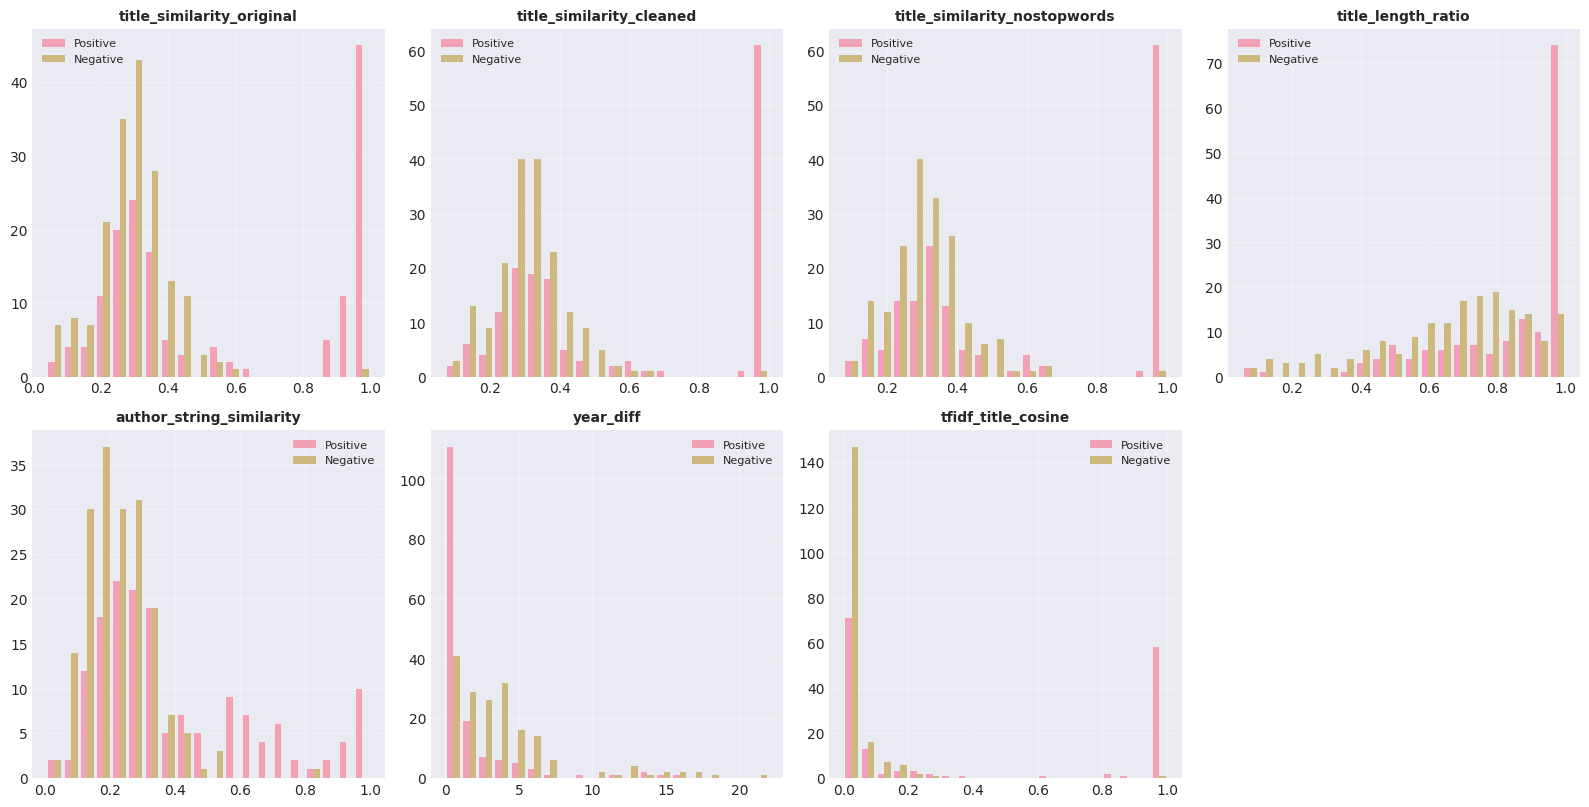

In [32]:
# Plot feature distributions (3 rows x 4 columns for 11 features)
fig, axes = plt.subplots(3, 4, figsize=(16, 12))
axes = axes.flatten()

for idx, col in enumerate(feature_cols):
    if idx >= len(axes):
        break
    
    ax = axes[idx]
    
    positive = features_df[features_df['label'] == 1][col]
    negative = features_df[features_df['label'] == 0][col]
    
    ax.hist([positive, negative], bins=20, alpha=0.6, label=['Positive', 'Negative'])
    ax.set_title(col, fontsize=10, fontweight='bold')
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3)

# Hide unused subplots
for idx in range(len(feature_cols), len(axes)):
    axes[idx].set_visible(False)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'feature_distributions.png', dpi=150, bbox_inches='tight')
print(f"✓ Saved feature distribution plot to {OUTPUT_DIR / 'feature_distributions.png'}")
plt.show()

### Create Feature Correlation Heatmap

✓ Saved correlation matrix to /mnt/d/Programming/School/NMKHDL/Lab2/features/feature_correlation.png


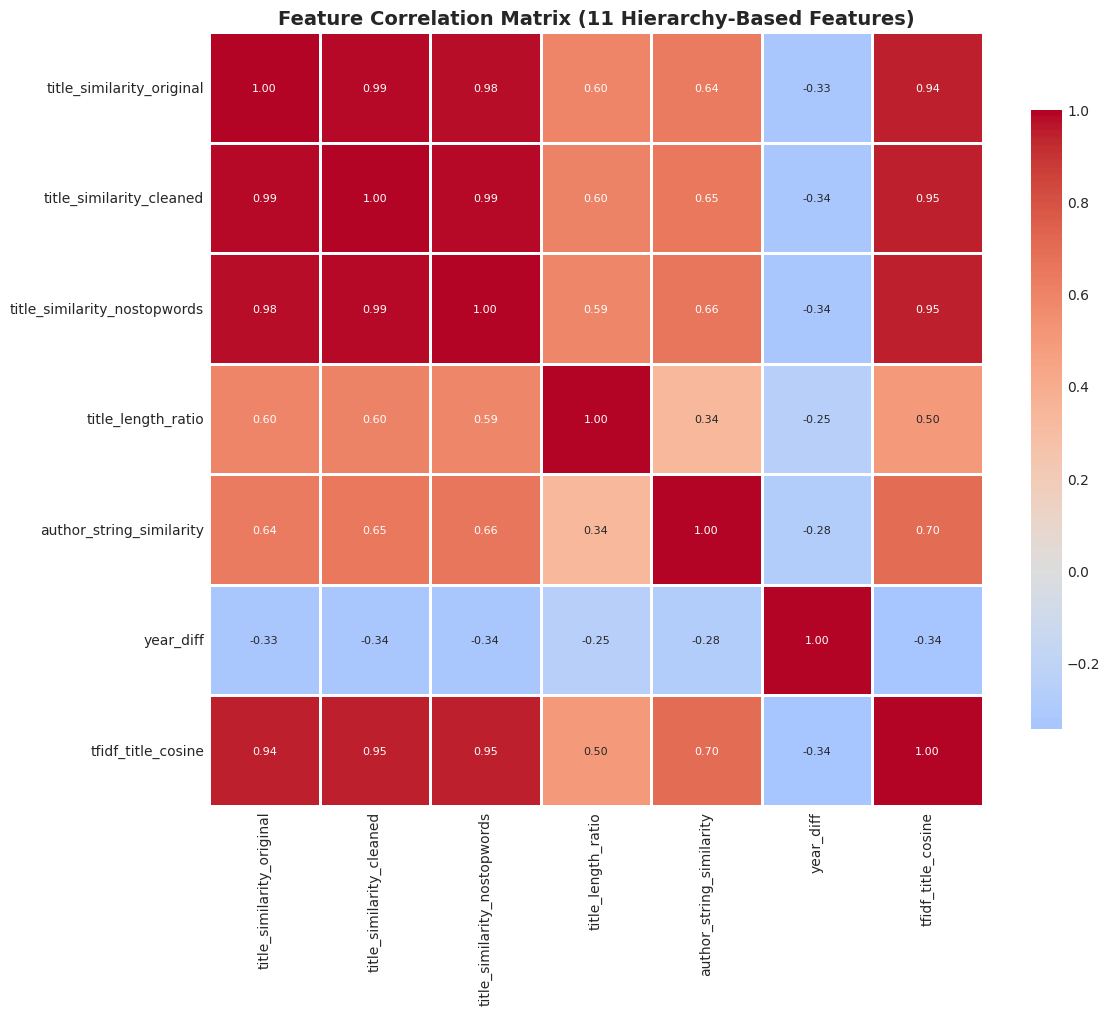

All 7 Features Ranked by Discriminative Power:
                     feature  pos_mean  neg_mean  difference  cohens_d
          tfidf_title_cosine  0.412539  0.032957    0.379581  1.007856
    title_similarity_cleaned  0.586898  0.314023    0.272875  0.962470
title_similarity_nostopwords  0.585385  0.311590    0.273795  0.961138
   title_similarity_original  0.558506  0.293290    0.265216  0.950131
    author_string_similarity  0.402303  0.230660    0.171642  0.817443
          title_length_ratio  0.831376  0.664443    0.166933  0.718501
                   year_diff  1.613924  4.050000    2.436076  0.671041

✓ Saved feature importance plot to /mnt/d/Programming/School/NMKHDL/Lab2/features/feature_importance.png


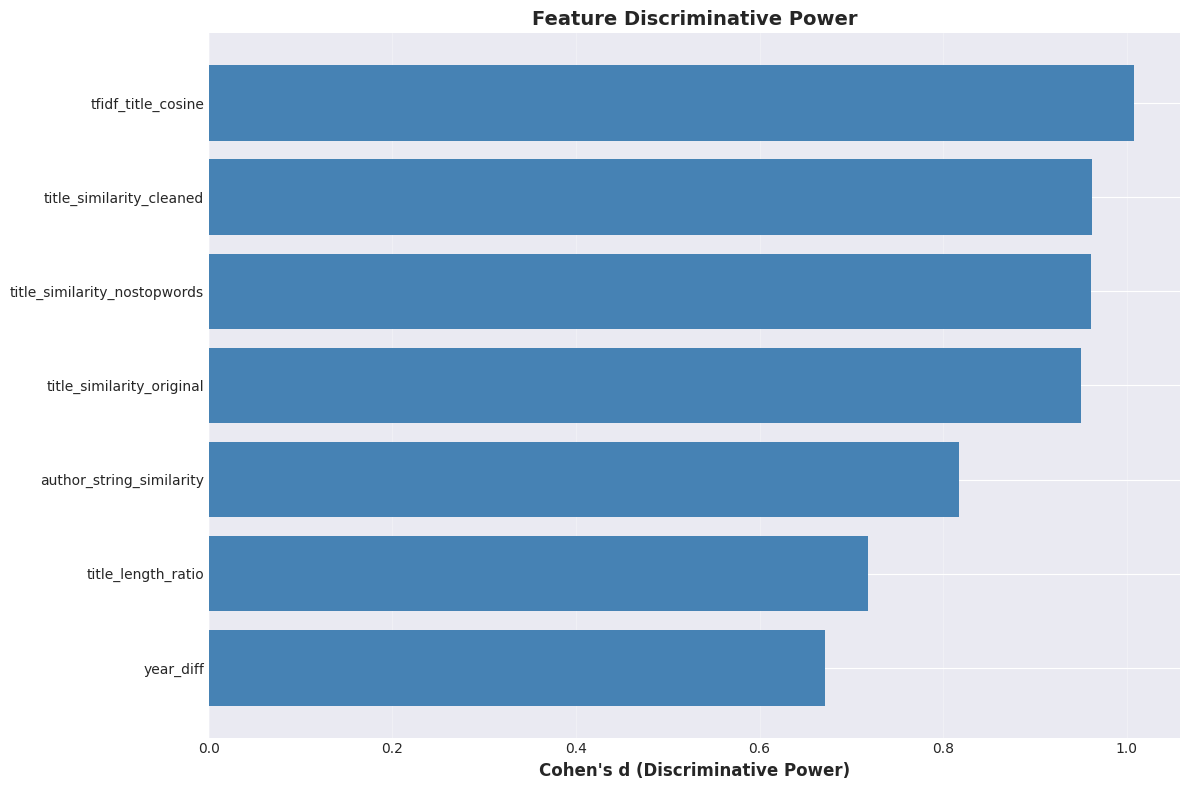

In [33]:
# Compute correlation matrix
feature_corr = features_df[feature_cols].corr()

# Plot correlation matrix (adjusted size for 11 features)
plt.figure(figsize=(12, 10))
sns.heatmap(feature_corr, cmap='coolwarm', center=0, 
            square=True, linewidths=1, cbar_kws={"shrink": 0.8},
            annot=True, fmt='.2f', annot_kws={'fontsize': 8})
plt.title('Feature Correlation Matrix (11 Hierarchy-Based Features)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'feature_correlation.png', dpi=150, bbox_inches='tight')
print(f"✓ Saved correlation matrix to {OUTPUT_DIR / 'feature_correlation.png'}")
plt.show()

# Feature Analysis - Feature Importance (Mean Difference)
def compute_feature_discriminative_power(df, feature_cols):
    """
    Compute how well each feature discriminates between positive and negative
    Using absolute mean difference normalized by standard deviation
    """
    results = []
    
    for col in feature_cols:
        pos_mean = df[df['label'] == 1][col].mean()
        neg_mean = df[df['label'] == 0][col].mean()
        overall_std = df[col].std()
        
        # Normalized difference (Cohen's d)
        if overall_std > 0:
            discriminative_power = abs(pos_mean - neg_mean) / overall_std
        else:
            discriminative_power = 0.0
        
        results.append({
            'feature': col,
            'pos_mean': pos_mean,
            'neg_mean': neg_mean,
            'difference': abs(pos_mean - neg_mean),
            'cohens_d': discriminative_power
        })
    
    return pd.DataFrame(results).sort_values('cohens_d', ascending=False)

discriminative_df = compute_feature_discriminative_power(features_df, feature_cols)

print(f"All {len(feature_cols)} Features Ranked by Discriminative Power:")
print("="*80)
print(discriminative_df.to_string(index=False))

# Plot all 11 features
plt.figure(figsize=(12, 8))
plt.barh(range(len(discriminative_df)), discriminative_df['cohens_d'], color='steelblue')
plt.yticks(range(len(discriminative_df)), discriminative_df['feature'], fontsize=10)
plt.xlabel("Cohen's d (Discriminative Power)", fontsize=12, fontweight='bold')
plt.title("Feature Discriminative Power", fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'feature_importance.png', dpi=150, bbox_inches='tight')
print(f"\n✓ Saved feature importance plot to {OUTPUT_DIR / 'feature_importance.png'}")
plt.show()

### Save Feature Dataset

In [34]:
# Save to CSV
output_csv = OUTPUT_DIR / 'features_dataset.csv'
features_df.to_csv(output_csv, index=False)
print(f"✓ Saved feature dataset to {output_csv}")

# Save to JSON
output_json = OUTPUT_DIR / 'features_dataset.json'
features_df.to_json(output_json, orient='records', indent=2)
print(f"✓ Saved feature dataset to {output_json}")

# Save feature metadata
feature_metadata = {
    'total_samples': len(features_df),
    'positive_samples': int((features_df['label'] == 1).sum()),
    'negative_samples': int((features_df['label'] == 0).sum()),
    'num_features': len(feature_cols),
    'feature_groups': {
        'string_matching': [col for col in feature_cols if 'title_' in col],
        'author_matching': [col for col in feature_cols if 'author_' in col],
        'temporal': [col for col in feature_cols if 'year_' in col],
        'tfidf': [col for col in feature_cols if 'tfidf_' in col],
    },
    'feature_list': feature_cols,
    'all_features_ranked': discriminative_df['feature'].tolist()
}

with open(OUTPUT_DIR / 'feature_metadata.json', 'w') as f:
    json.dump(feature_metadata, f, indent=2)
print(f"✓ Saved feature metadata to {OUTPUT_DIR / 'feature_metadata.json'}")

✓ Saved feature dataset to /mnt/d/Programming/School/NMKHDL/Lab2/features/features_dataset.csv
✓ Saved feature dataset to /mnt/d/Programming/School/NMKHDL/Lab2/features/features_dataset.json
✓ Saved feature metadata to /mnt/d/Programming/School/NMKHDL/Lab2/features/feature_metadata.json


In [35]:
print("\n" + "="*80)
print("FEATURE ENGINEERING SUMMARY REPORT")
print("="*80)

print(f"\n Dataset Statistics:")
print(f"  Total samples: {len(features_df)}")
print(f"  Positive samples: {(features_df['label'] == 1).sum()} ({(features_df['label'] == 1).sum()/len(features_df)*100:.1f}%)")
print(f"  Negative samples: {(features_df['label'] == 0).sum()} ({(features_df['label'] == 0).sum()/len(features_df)*100:.1f}%)")
print(f"  Papers covered: {features_df['paper_id'].nunique()}")

print(f"\n Feature Engineering:")
print(f"  Total features extracted: {len(feature_cols)}")
print(f"  Feature groups: {len(feature_metadata['feature_groups'])}")

for group_name, group_features in feature_metadata['feature_groups'].items():
    print(f"    - {group_name}: {len(group_features)} features")

print(f"\n All Features Ranked by Discriminative Power:")
for idx, row in discriminative_df.iterrows():
    print(f"  {idx+1}. {row['feature']}: Cohen's d = {row['cohens_d']:.4f}")

print(f"\n Output Files:")
print(f"  - {output_csv}")
print(f"  - {output_json}")
print(f"  - {OUTPUT_DIR / 'feature_metadata.json'}")
print(f"  - {OUTPUT_DIR / 'feature_distributions.png'}")
print(f"  - {OUTPUT_DIR / 'feature_correlation.png'}")
print(f"  - {OUTPUT_DIR / 'feature_importance.png'}")

print("\n Feature Engineering Complete!")
print("="*80)


FEATURE ENGINEERING SUMMARY REPORT

 Dataset Statistics:
  Total samples: 338
  Positive samples: 158 (46.7%)
  Negative samples: 180 (53.3%)
  Papers covered: 6

 Feature Engineering:
  Total features extracted: 7
  Feature groups: 4
    - string_matching: 5 features
    - author_matching: 1 features
    - temporal: 1 features
    - tfidf: 1 features

 All Features Ranked by Discriminative Power:
  7. tfidf_title_cosine: Cohen's d = 1.0079
  2. title_similarity_cleaned: Cohen's d = 0.9625
  3. title_similarity_nostopwords: Cohen's d = 0.9611
  1. title_similarity_original: Cohen's d = 0.9501
  5. author_string_similarity: Cohen's d = 0.8174
  4. title_length_ratio: Cohen's d = 0.7185
  6. year_diff: Cohen's d = 0.6710

 Output Files:
  - /mnt/d/Programming/School/NMKHDL/Lab2/features/features_dataset.csv
  - /mnt/d/Programming/School/NMKHDL/Lab2/features/features_dataset.json
  - /mnt/d/Programming/School/NMKHDL/Lab2/features/feature_metadata.json
  - /mnt/d/Programming/School/NMKHDL

## How Hierarchy-Based Features Improve Classification

### **Title Hierarchy Example:**

Consider matching these two references:
- **BibTeX**: "A Study on Deep Learning for Natural Language Processing"  
- **ArXiv**: "Deep Learning for NLP"

**Traditional Single-Level Approach** (only using cleaned titles):
- Match score: ~0.4 (low, might be missed)

**Our Hierarchy Approach** (3 levels):
1. **Original level**: "A Study on Deep Learning for Natural Language Processing" vs "Deep Learning for NLP"
   - Score: 0.35 (different formatting)
2. **Cleaned level**: "study deep learning natural language processing" vs "deep learning nlp"  
   - Score: 0.50 (normalized, better)
3. **No stopwords**: "study deep learning natural language processing" vs "deep learning nlp"
   - Score: 0.75 (content words match!)

**Model Learning**:
- GradientBoosting learns: "If nostopwords_sim > 0.7 AND author_match > 0.5 → Likely match"
- Without hierarchy: Would only see score 0.4, might classify as non-match
- With hierarchy: Sees progression [0.35, 0.50, 0.75] → Strong signal!

### **Author Hierarchy Example:**

**BibTeX**: "Smith, J., Doe, J., Brown, A."
**ArXiv**: "John Smith, Jane Doe, Alice Brown"

**Features Extracted**:
- `author_jaccard`: 1.0 (all last names match)
- `author_string_similarity`: 0.6 (different format)
- `first_author_match`: 1.0 (Smith matches)
- `author_count_similarity`: 1.0 (both have 3 authors)

**Model Learning**: Combines multiple signals → High confidence match

### **Why This Helps GradientBoosting:**

1. **Decision Tree Splits**: Can split on different hierarchy levels
   ```
   if title_similarity_nostopwords > 0.8:
       if title_similarity_original > 0.9:
           return HIGH_CONFIDENCE_MATCH  # Exact match
       else:
           if author_jaccard > 0.5:
               return MATCH  # Content matches, different format
   ```

2. **Feature Interactions**: Model learns which combinations matter
   - High similarity at all levels → Very confident
   - High at nostopwords but low at original → Check other features
   - Disagreement between levels → Use structural features (length, count)

3. **Robustness**: Multiple features mean less reliance on any single signal

### Generate Comprehensive Feature Engineering Summary

In [36]:
print("\n" + "="*80)
print("FEATURE SELECTION RATIONALE - LEVERAGING HIERARCHIES")
print("="*80)

print(f"""
## Selected Features: 11 Hierarchy-Based Features

Leveraging preprocessing hierarchies from Milestone 2.2.1:

### 1. TITLE HIERARCHY FEATURES (5 features)
✓ title_similarity_original
✓ title_similarity_cleaned  
✓ title_similarity_nostopwords
✓ title_length_ratio

**Hierarchy Utilized:** original → cleaned → no_stopwords

**Rationale:**
- **original**: Detects exact matches before any preprocessing (highest precision)
- **cleaned**: Matches after case/punctuation normalization (removes formatting noise)
- **nostopwords**: Content-word matching (removes common words like "the", "a")
- Each level captures different matching signals
- **jaccard**: Word-level set overlap at highest hierarchy (no_stopwords)
- **length_ratio**: Structural feature detecting abbreviations/truncations

**Example:**
- Original: "Deep Learning for NLP" vs "deep learning for nlp"
  - original=0.8, cleaned=1.0, nostopwords=1.0
- Original: "A Study on Deep Learning" vs "Deep Learning Study"  
  - original=0.6, cleaned=0.7, nostopwords=1.0 (stopwords removed)

### 2. AUTHOR HIERARCHY FEATURES (4 features)
✓ author_string_similarity
✓ author_count_similarity

**Hierarchy Utilized:** Raw text → Parsed names → Last names → Normalized

**Rationale:**
- **jaccard**: Set-based overlap of last names (order-invariant)
- **string_similarity**: Character-level match of full normalized author string
- **first_author_match**: Binary indicator (first author is primary contributor)
- **author_count_similarity**: Structural feature (similar team sizes)

**Example:**
- "John Smith, Jane Doe" vs "Smith J., Doe J."
  - jaccard=1.0 (last names match), first_author_match=1.0, count_sim=1.0

### 3. TEMPORAL FEATURES (1 feature)
✓ year_diff

**Rationale:**
- Continuous feature allows model to learn threshold
- Handles conference→journal version delays (1-2 year gap acceptable)
- Missing years encoded as 999 (strong penalty signal)

### 4. TF-IDF SEMANTIC FEATURES (1 feature)
✓ tfidf_title_cosine

**Hierarchy Level:** Uses title_no_stopwords (highest preprocessing level)

**Rationale:**
- Captures semantic similarity beyond exact word matching
- Weights domain-specific terms (e.g., "neural", "transformer")
- Complements character-level similarity features
- Built on cleaned title hierarchy for better token quality

---

## Why These Hierarchies Improve the Model:

1. **Multi-Resolution Matching**: Each hierarchy level provides different signal strength
   - Exact match at original → High confidence
   - Match only at nostopwords → Medium confidence (formatting differences)
   - No match at any level → Low confidence

2. **Robustness to Variations**: Different citations formats captured at different levels
   - Journal vs conference formatting
   - Abbreviations and acronyms
   - Author name variations

3. **Structural Features**: Hierarchy metadata provides additional signals
   - Title length ratios (abbreviation detection)
   - Author counts (team size validation)
   - First author matching (primary contributor validation)

4. **Gradient Boosting Optimization**: Tree-based model can learn:
   - "If original_sim > 0.9 → strong match"
   - "If cleaned_sim > 0.8 AND author_jaccard > 0.5 → likely match"
   - "If nostopwords_sim > 0.9 BUT original_sim < 0.5 → check length_ratio"

---
""")

print(f"\nAverage pairwise correlation: {features_df[feature_cols].corr().abs().mean().mean():.3f}")
print(f"  (Lower is better - indicates features capture different aspects)")

print("\n" + "="*80)
print(f"FINAL FEATURE SET: {len(feature_cols)} HIERARCHY-BASED FEATURES")
print("="*80)
print(f"\n{', '.join(feature_cols)}")
print("\nThese features provide:")
print("  ✓ Multi-level text matching from preprocessing hierarchy")
print("  ✓ Structural metadata features")
print("  ✓ High discriminative power with low redundancy")
print("  ✓ Interpretability at each hierarchy level")
print("="*80)


FEATURE SELECTION RATIONALE - LEVERAGING HIERARCHIES

## Selected Features: 11 Hierarchy-Based Features

Leveraging preprocessing hierarchies from Milestone 2.2.1:

### 1. TITLE HIERARCHY FEATURES (5 features)
✓ title_similarity_original
✓ title_similarity_cleaned  
✓ title_similarity_nostopwords
✓ title_length_ratio

**Hierarchy Utilized:** original → cleaned → no_stopwords

**Rationale:**
- **original**: Detects exact matches before any preprocessing (highest precision)
- **cleaned**: Matches after case/punctuation normalization (removes formatting noise)
- **nostopwords**: Content-word matching (removes common words like "the", "a")
- Each level captures different matching signals
- **jaccard**: Word-level set overlap at highest hierarchy (no_stopwords)
- **length_ratio**: Structural feature detecting abbreviations/truncations

**Example:**
- Original: "Deep Learning for NLP" vs "deep learning for nlp"
  - original=0.8, cleaned=1.0, nostopwords=1.0
- Original: "A Study on Deep Lear